## Auto Tetris Game

I will use SARSA with linear function approximation to play the Tetris game.

### Problem Desciption

Consider the game of Tetris. The player is continually given pieces of varying shape that must be positioned and rotated, then dropped on the pieces below. Since these pieces begin to pile up, the player must try to stack them efficiently. Furthermore, if the player manages to complete a row, then that row dissapears thus freeing up more space. The objective is to keep the height as low as possible. Note that the shape of each subsequent piece is random thus making it difficult to plan ahead (non-deterministic).

We consider a smaller version of the Tetris game. The pieces are at most 2x2:

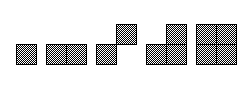

The area where pieces are placed is 6 units wide, and the maximum working height is 2. Some examples are:

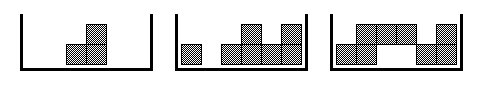

As in the regular game of tetris, rows are removed when they become full. The following picture (going left to right) shows how this happens when a piece is added:

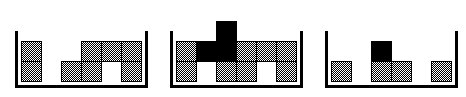

When the working height of 2 is exceeded, the bottom row is removed and the total height is incremented:

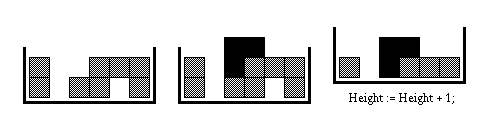

Note that a lower height indicates a better performance of the agent.

An example of a state that should have a low value is:

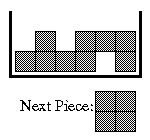

Given the next piece is a solid 2x2 block, the agent will be forced to increase the total height of the pile by 2 units. Therefore it is desirable to avoid getting into states like these.

Reference: This small version of the Tetris game and the rules are from https://melax.github.io/tetris/tetris.html


### Formulation

- *State* $s$:
    
    The state $s$ contains two numbers, i.e., $s=(s_{\mathrm{gam}},s_{\mathrm{pie}})$. The number $s_{\mathrm{gam}}$ represents the game area, and the number $s_{\mathrm{pie}}$ represents the next piece. We use binary codes to encode the shape, where "1" means that there is a square in the correponding space, while "0" means that the space is empty. The 12 bits of the binary representation of $s_{\mathrm{gam}}$ encode the whole game area, where the lower 6 bits encode the lower layer of the game area and the higher 6 bits encode the higher layer. The 4 bits of the binary representation of $s_{\mathrm{pie}}$ encode the next piece, where the lower 2 bits encode the lower layer of the next piece and the higher 2 bits encode the higher layer. Take the following state as an example:
    
    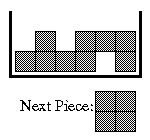
    
    In the above state, the binary representation of $s_{\mathrm{gam}}$ should be 010111 111101, whose decimal number is $1533$;
    the binary representation of $s_{\mathrm{pie}}$ should be 1111, whose decimal number is $15$. Hence, $s=(1533, 15)$.
    
    Note that two different $s_{\mathrm{pie}}$ could have the same shape after rotation. For example, there are four possible $s_{\mathrm{pie}}$ that can represent a single-square piece, i.e., the binary number 0001, 0010, 1000, or 0100.


- *Action $a$*:
    
    The action $a$ also contains two numbers, i.e., $a=(a_{\mathrm{pos}},a_{\mathrm{rot}})$. The number $a_{\mathrm{pos}}\in\{0,1,2,3,4\}$ represents the position you want to put the next piece down, counting from right to left. The number $a_{\mathrm{rot}}\in\{0,1,2,3\}$ represents the clockwise rotation of the next piece. $0$ means no rotation.
    
    - Note: Taking the same action on different representations $s_{\mathrm{pie}}$ of the same shape could have different results. For example, $s_{\mathrm{pie}}=0001$ is different from $s_{\mathrm{pie}}=0010$ when taking the action $a=(0, 0)$. For $s_{\mathrm{pie}}=0001$, $a_{\mathrm{pos}}=0$ means that the single-sqaure piece will drop down at the rightmost position, but for $s_{\mathrm{pie}}=0010$, $a_{\mathrm{pos}}=0$ means that the single-sqaure piece will drop down one space left.
    

- *Reward $r(s,a)$*:
    
    If the working height of 2 is exceeded by one, i.e., the total height is incremented by one, then a reward $-1$ occurs;
    
    If the working height of 2 is exceeded by two, i.e., the total height is incremented by two, then a reward $-2$ occurs.
    

- *Objective*: Maximize the expected total discounted reward:

    $$\mathbb{E} \left[\sum_{t=0}^{\infty} \gamma^t r(s_t,a_t)\right]$$
    
    where $\gamma=0.9$ denotes the discount factor.


In [1]:
import numpy as np
from unittest.mock import patch
from assets.tetris_env import TetrisEnv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
env = TetrisEnv(seed=0)

### SARSA with Linear Function Approximation

We will use SARSA with linear function approximation to play the Tetris game.

### Background
Given an experience tuple consisting of the previous state $s_{t-1}$, previous action $a_{t-1}$, current state $s_{t}$, current action $a_{t}$, and reward $r(s_{t-1},a_{t-1})$, we need to establish an update rule for the estimate $\tilde{\theta}$ of the coefficient $\theta$ in the linear functional approximation of the Q-function $Q^*(s,a) \approx \theta^T \phi(s,a)$ to the optimal policy.

### Solution
The update rule aims to improve the approximation of the Q-function $Q^*$ by the linear model by adjusting the estimate $\tilde{\theta}$ based on new experience. By applying this update iteratively, the agent can learn more effective policies through interaction with the environment.

In the context of SARSA with linear function approximation, the update formula for the estimate $\tilde{\theta}$ of the coefficient $\theta$ in the Q-function approximation can be expressed as follows:

$$
\tilde{\theta} \leftarrow \tilde{\theta} + \alpha \left[ r(s_{t-1},a_{t-1}) + \gamma \tilde{\theta}^T \phi(s_t, a_t) - \tilde{\theta}^T \phi(s_{t-1}, a_{t-1}) \right] \phi(s_{t-1}, a_{t-1})
$$

Where:
- $\alpha$ is the learning rate.
- $\gamma$ is the discount rate.
- $r(s_{t-1},a_{t-1})$ is the reward received after executing action $a_{t-1}$ in state $s_{t-1}$.
- Let $\phi(s, a)$ be a feature vector representing state $s$ and action $a$.


### Implementation

Below are useful elements of the `LFAAgent` class:

  - `self.gamma`: discount factor

  - `self.theta`: the weight vector to be learned

  - `self.learning_rate`: learning rate.

  - `self.epsilon`: $\epsilon$ for the epsilon-greedy exploration.

  - `self.rng`: a random generator (see https://numpy.org/doc/stable/reference/random/generator.html), we will use the following functions:

    - `self.rng.random()`: generate a random number in [0,1].

    - `self.rng.choice(n)`: generate random integer in {0,1,..., n-1}.

  - function `self.select_action()`:

    - input `state_game` and `state_piece`: $s_{\mathrm{gam}}$ and $s_{\mathrm{pie}}$, the state of the game area and next piece in the current step.

    - output `action_pos` and `action_rot`: $a_{\mathrm{pos}}$ and $a_{\mathrm{rot}}$, the position where the agent will put the next piece down and rotation.

  - function `self.train()`:

    - input `pre_state_game`, `pre_state_piece`: state in the previous step.
    - input `pre_action_pos`, `pre_action_rot`: the action in the previous step.
    - input `pre_reward`: the reward received in the previous step.
    - input `cur_state_game`, `cur_state_piece`: the current state.
    - input `cur_action_pos`, `cur_action_rot`: the action that the agent takes in the current step.
    - input `done`: `done=0` means that the current episode does not terminate, and `done=1` means that the current episode terminates (length 100).

  - function `self.phi()`:
    - input `state_game`, `state_piece`: $s_{gam}$ and $s_{pie}$, the state of the game area and the state of the next piece in the current step.
    - input `action_pos`, `action_rot`: $a_{pos}$ and $a_{rot}$, the position where the agent puts the next piece down in the current step and the rotation.
    - output `feature_vec`: the feature vector $\phi(s,a) = \phi(s_{gam}, s_{pie}, a_{pos}, a_{rot})$.

In [2]:
class LFAAgent:
    def __init__(self, seed):
        """
        Initialize the coefficients theta and set hyper-parameters.
        """
        self.gamma = 0.9  # Discount factor
        self.theta = np.zeros((640,))  # The weight vector to be learned
        self.learning_rate = 0.01  # Initial learning rate
        self.learning_rate_decay = 0.995  # Learning rate decay for each episode
        self.min_learning_rate = 0.001  # Minimum learning rate
        self.epsilon = 0.5  # Initial epsilon for exploration
        self.epsilon_decay = 0.98  # Epsilon decay for each episode

        if seed is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = np.random.default_rng(seed)

    def select_action(self, state_game, state_piece):
        """
        This function returns an action for the agent to take.
        """
        if self.rng.random() < self.epsilon:
            # With probability self.epsilon, choose an action uniformly at random
            action_pos = self.rng.choice(5)  # Choose position randomly
            action_rot = self.rng.choice(4)  # Choose rotation randomly
        else:
            # With probability 1-self.epsilon, select the action which has the largest Q value
            # Implement the logic to find the action with the largest Q value
            max_q_value = -np.inf
            action_pos = 0
            action_rot = 0
            for pos in range(5):
                for rot in range(4):
                    feature_vec = self.phi(state_game, state_piece, pos, rot)
                    q_value = np.dot(self.theta, feature_vec)
                    if q_value > max_q_value:
                        max_q_value = q_value
                        action_pos = pos
                        action_rot = rot
        return action_pos, action_rot

    def train(self, pre_state_game, pre_state_piece, pre_action_pos, pre_action_rot, pre_reward,
              cur_state_game, cur_state_piece, cur_action_pos, cur_action_rot, done):
        """
        This function is used for the update of the weight vector self.theta.
        """

        # Feature vector for previous state action
        pre_feature_vector = self.phi(pre_state_game, pre_state_piece, pre_action_pos, pre_action_rot)
        # Feature vector for current state action
        cur_feature_vector = self.phi(cur_state_game, cur_state_piece, cur_action_pos, cur_action_rot)

        # Compute temporal difference
        td_target = pre_reward + self.gamma * np.dot(self.theta, cur_feature_vector)
        td_error = td_target - np.dot(self.theta, pre_feature_vector)

        # Update theta
        self.theta += self.learning_rate * td_error * pre_feature_vector

        # Update learning rate and epsilon
        if done != 0:
            self.learning_rate = max(self.learning_rate * self.learning_rate_decay, self.min_learning_rate)
            self.epsilon = max(self.epsilon * self.epsilon_decay, 0)

    @staticmethod
    def rotate(p, action_rot):
        """
        Rotate the piece `p` clockwise.
        """
        while action_rot > 0:
            q = p >> 2
            p = (2 if p & 1 != 0 else 0) + (2 << 2 if p & 2 != 0 else 0) + \
                (1 << 2 if q & 2 != 0 else 0) + (1 if q & 1 != 0 else 0)
            action_rot -= 1
        if p % (1 << 2) == 0:
            p >>= 2
        return p

    def phi(self, state_game, state_piece, action_pos, action_rot):
        """
        Implement the feature function phi(s, a).
        """
        feature_vec = np.zeros((640,))
        feature_s_vec = np.zeros((8,))
        h_row = np.unpackbits(np.array([state_game >> 6], dtype=np.uint8))
        l_row = np.unpackbits(np.array([state_game & 63], dtype=np.uint8))
        heights = h_row.astype(int) * 2 + (l_row - h_row == 1).astype(int)
        feature_s_vec[0] = np.max(heights)  # the height of the highest column
        feature_s_vec[1] = np.sum(h_row.astype(int) - l_row.astype(int) == 1)  # holes
        wells = 0
        for i in range(2, 8):
            if (i == 2 or heights[i] - heights[i - 1] < 0) and (i == 7 or heights[i + 1] - heights[i] > 0):
                wells += 1
        feature_s_vec[2] = wells  # wells

        for i in range(3, 8):
            feature_s_vec[i] = heights[i] - heights[i - 1]  # differences in height between neighboring columns

        piece_rotated = self.rotate(state_piece, action_rot)

        action = action_pos * 16 + piece_rotated
        feature_vec[action * 8:(action + 1) * 8] = feature_s_vec

        return feature_vec


Your actions during the last episode:
step 1: 
state of the game area:
000000
000000
next piece:
00
01
actions:
position= 0 rotation= 0


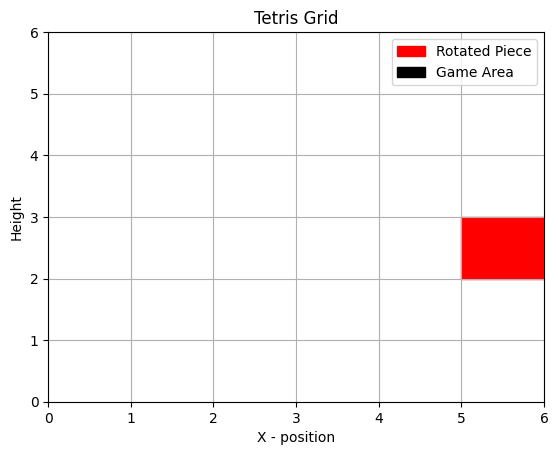

step 2: 
state of the game area:
000000
000001
next piece:
00
10
actions:
position= 1 rotation= 2


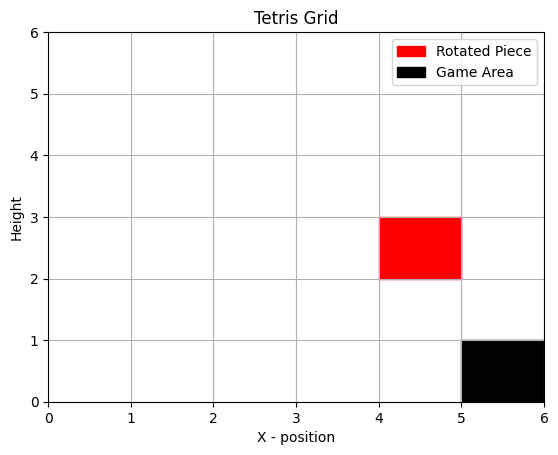

step 3: 
state of the game area:
000000
000011
next piece:
11
01
actions:
position= 2 rotation= 2


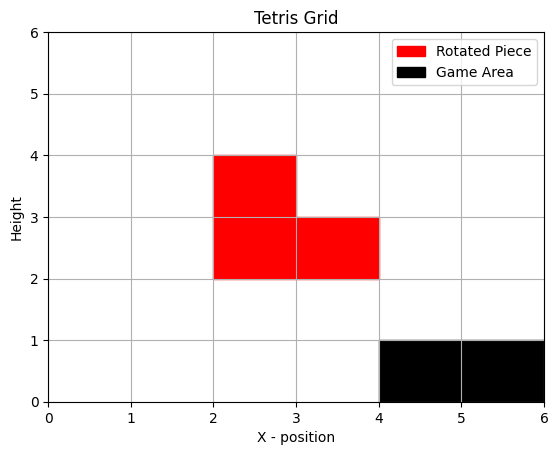

step 4: 
state of the game area:
001000
001111
next piece:
10
11
actions:
position= 4 rotation= 1


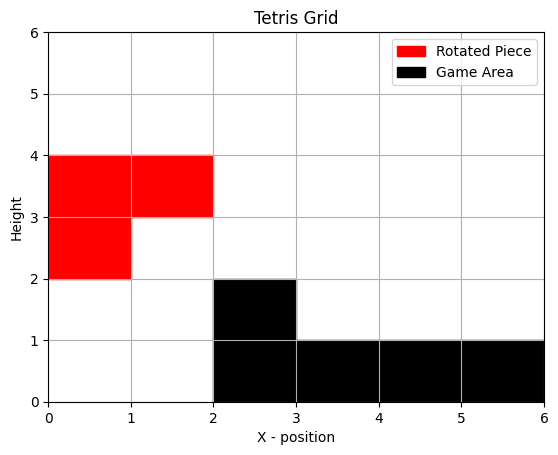

step 5: 
state of the game area:
111000
101111
next piece:
01
11
actions:
position= 0 rotation= 0


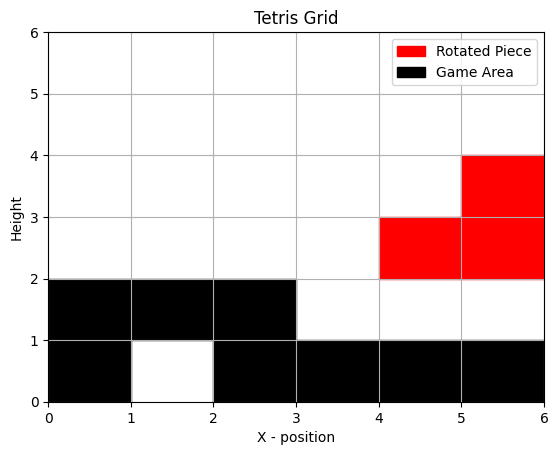

step 6: 
state of the game area:
000001
111011
next piece:
10
01
actions:
position= 2 rotation= 0


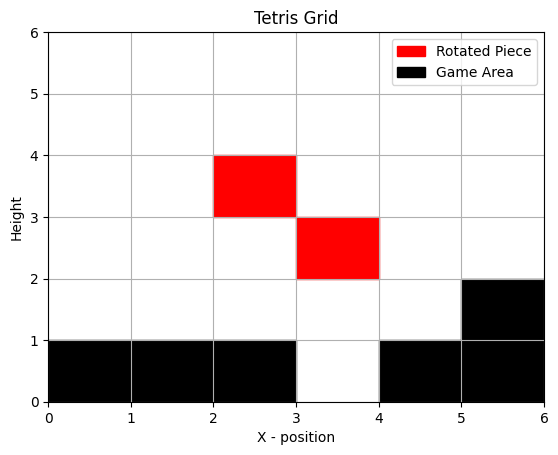

step 7: 
state of the game area:
000000
001001
next piece:
01
01
actions:
position= 4 rotation= 1


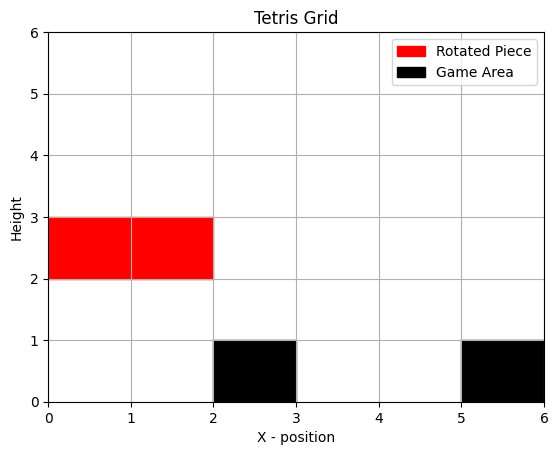

step 8: 
state of the game area:
000000
111001
next piece:
01
01
actions:
position= 0 rotation= 2


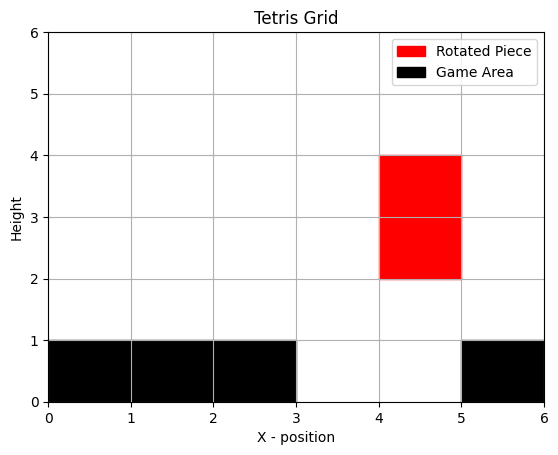

step 9: 
state of the game area:
000010
111011
next piece:
00
11
actions:
position= 1 rotation= 1


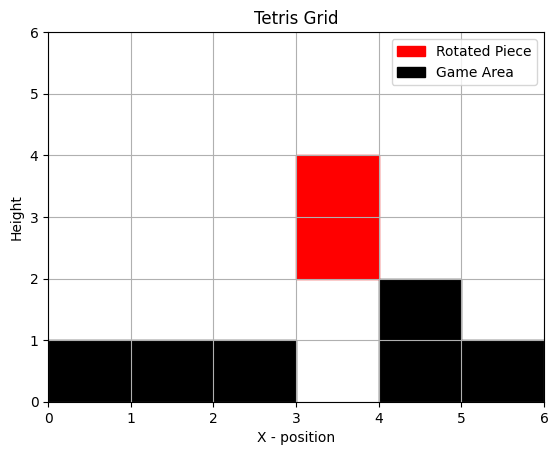

step 10: 
state of the game area:
000000
000110
next piece:
00
11
actions:
position= 0 rotation= 3


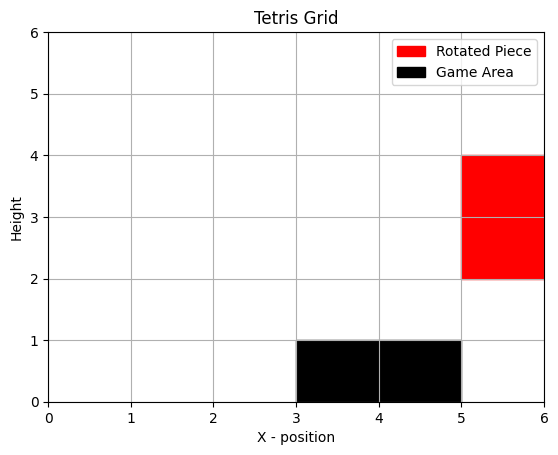


Your total reward averaged over the last 100 episodes:
-13.480


In [3]:
np.random.seed(0)
agent = LFAAgent(seed=0)
print("Your actions during the last episode:")
total_reward = 0.0
num_ep = 500

for ep in range(num_ep):
    state_game, state_piece = env.reset()
    pre_state_game = None
    pre_state_piece = None
    pre_action_pos = None
    pre_action_rot = None
    pre_reward = None
    for step in range(100):
        action_pos, action_rot = agent.select_action(state_game, state_piece)
        
        if ep == num_ep - 1 and step < 10:
            print('step %d: ' % (step + 1))
            print('state of the game area:')
            print(format(state_game >> 6, 'b').zfill(6))
            print(format(state_game & 63, 'b').zfill(6))
            print('next piece:')
            print(format(state_piece >> 2, 'b').zfill(2))
            print(format(state_piece & 3, 'b').zfill(2))
            print('actions:')
            print('position=', action_pos, 'rotation=', action_rot)
            env.visualize(action_pos, action_rot)
        
        next_state_game, next_state_piece, reward = env.step(action_pos, action_rot)

        if 1 <= step < 99:
            agent.train(pre_state_game, pre_state_piece, pre_action_pos, pre_action_rot, pre_reward,
                        state_game, state_piece, action_pos, action_rot, 0)
        elif step == 99:
            agent.train(pre_state_game, pre_state_piece, pre_action_pos, pre_action_rot, pre_reward,
                        state_game, state_piece, action_pos, action_rot, 1)

        if num_ep - ep <= 100:
            total_reward = total_reward + reward

        pre_state_game = state_game
        pre_state_piece = state_piece
        pre_action_pos = action_pos
        pre_action_rot = action_rot
        pre_reward = reward
        state_game = next_state_game
        state_piece = next_state_piece

total_reward = total_reward / 100
print("")
print("Your total reward averaged over the last %d episodes:\n%.3f" % (100, total_reward))

# Hidden Test 1: check if the total reward is larger than -80

In [4]:
# Hidden Test 2: check if the total reward is larger than -50

In [5]:
# Hidden Test 3: check if the total reward is larger than -20